# Segway

In [1]:
from ipywidgets import interact
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from numerical_analysis import *
from matplotlib import animation, rc
from IPython.display import HTML

import sympy  as sp
import numpy as np
import control as ct
import control.matlab as ct_matlab

import slycot

## Deriving the equations

<!-- ![Alt text](./segway.png "a title") -->


The segway and its degrees of freedom are shown below 

<img src="./segway.png" alt="drawing" width="500"/>


Here, $x$ is the position of the wheel along the x-axis, $\theta$ is the angle between the swgway wheel and the vertical and $\phi$ is the wheel angular position measure with respect to the body. $\phi$ will be the angle measure by the wheel encoder

The dynamics is derived using Lagrangian mechanics and the control gain is calculated using LQR. Please see the cart_pendulum_control_Lagrangian_dynamics  notebook to get more details again Lagrangian dynamics

In [2]:
t   = sp.symbols('t')

# Defining lambdas for making derivatives terse
ddt = lambda f  :sp.diff(f, t)
ddx = lambda f,x:sp.diff(f, x)

# State variables
x     = sp.Function('x' )
theta = sp.Function('theta')

x_d  = ddt(x(t))
x_dd = ddt(x_d)
theta_d  = ddt(theta(t))
theta_dd = ddt(theta_d)

states     = [x(t), theta(t)]
states_der = [ddt(i) for i in states]

# Paramters
mw, mb, r, l, g = sp.symbols('mw, mb, r, l, g ')

# Moment of inertia of the wheel
i_m = mw*r**2 

# System parameters
param_vals = {
    "mw" : 10,
    "mb" : 1,
    "g"  : -10,
    "l"  : 1,
    "r"  : 0.1
}

# Torque
tau       = sp.symbols('tau')

# Position
wheel_x = x(t)
wheel_y = 0
wheel_pos = [wheel_x, wheel_y]

body_x = l*sp.sin(theta(t)) + wheel_x
body_y = l*sp.cos(theta(t))
body_pos  = [body_x,  body_y]

phi    = x(t)/(2*r) - theta(t)
phi_d  = ddt(phi)

# Velocity
wheel_vel = [ddt(x) for x in wheel_pos]
body_vel  = [ddt(x) for x in body_pos]

wheel_vel_squared_sum = sum(i**2 for i in wheel_vel)
body_vel_squared_sum  = sum(i**2 for i in body_vel )

### The energies

In [3]:
ke = mw*wheel_vel_squared_sum/2 + mb*body_vel_squared_sum/2 + i_m*(phi_d + theta_d)**2/2
pe = -mb*g*body_y

p_nc = tau*(phi_d + theta_d) + (-tau)*theta_d
q_nc = [ddx(p_nc, x) for x in states_der]

L = ke - pe


### Evaluating the Euler Lagrangian equation

In [4]:

DEs = [
    ddt(sp.diff(L, x_d))     - sp.diff(L, x(t) )    - q_nc[0],
    ddt(sp.diff(L, theta_d)) - sp.diff(L, theta(t)) - q_nc[1],
]
DEs = [DE.simplify() for DE in DEs]

# Solving to get explicit values for thetae two state double derivatives
DEexplicit = sp.solve(DEs,           [x_dd, theta_dd]) # Solving
DEexplicit = [DEexplicit[i] for i in [x_dd, theta_dd]] # Extracting thetae solutions
DEexplicit = [DE.expand().simplify() for DE in DEexplicit]  # Simplifying thetae solution

### Converting expressions into functions

In [5]:
y1, y2, y1d, y2d = sp.symbols('y1, y2, y1d, y2d')
substitutions = {
    x(t)  : y1,
    theta(t) : y2,

    ddt(x(t)) : y1d,
    ddt(theta(t)): y2d,
}

y1dd, y2dd    = [i.subs(substitutions) for i in DEexplicit]
y1dd_function = sp.lambdify((y1, y1d, y2, y2d, t, tau, mw, mb, l, r, g), y1dd) 
y2dd_function = sp.lambdify((y1, y1d, y2, y2d, t, tau, mw, mb, l, r, g), y2dd) 


### The state function

In [6]:
def get_Sewgway_Lagrangian(X, t, uf, mw, mb, l, r, g):
    tau  = uf(X)
    x, v, theta, omega = X
    x_d = v
    v_d =     y1dd_function(x, v, theta, omega, t, tau, mw, mb, l, r, g)
    theta_d = omega
    omega_d = y2dd_function(x, v, theta, omega, t, tau, mw, mb, l, r, g)

    return np.array([x_d, v_d, theta_d, omega_d])


# Simulating unforced segway

In [7]:
# No control law, free moving
control_no = lambda x:0 
push = lambda x:1

# Simulation parameters
dt = 0.001
t0 = 0.0
tn = 10.0
ts = np.arange(t0, tn, dt)
t_step = [0.0, dt]

# Initial condition
x0 = np.array([0.0, 0.0, np.pi/2, 0.0])

# Integrate
result = odeint(
        get_Sewgway_Lagrangian, x0, ts, 
        args=(control_no, param_vals["mw"], param_vals["mb"], param_vals["l"], param_vals["r"], param_vals["g"])
    )

### Animation function

In [8]:
def animate_segway(result, ts, Xs):
    """
    Accepts wheel state information and returns an animation
    """
    # Extracting the symbols
    x1, x2 = Xs

    # Setting axes range
    x_range = [-3,   3]
    y_range = [-1.1, 1.1]
    delta   = lambda ls: ls[1] - ls[0]
    aspect  = (delta(x_range)) / (delta(y_range))

    # setting matplotlib parameters
    scale = 3
    plt.rcParams['figure.figsize'] = [aspect * scale, scale]
    plt.rcParams.update({'font.size': 18})
    plt.rcParams['animation.html'] = 'jshtml'


    # Selecting the animation range
    res_plot = result[::50]
    ts_plot  = ts[::50]

    # Setting up the plot
    fig, ax      = plt.subplots()
    pend_plot,   = plt.plot([],[], 'o-', linewidth=2, ms=10, markerfacecolor='r')
    wheel_plot,  = plt.plot([],[], 'o', ms=20) 
    wheel_marker_plot, = plt.plot([],[], 'o', ms=5) 
    

    print(type(pend_plot))

    def init():
        ax.set_xlim(x_range[0], x_range[1])
        ax.set_ylim(y_range[0], y_range[1])
        ax.set_aspect('equal')

    def animate(iter):
        x_wheel, _, th_pend, _ = res_plot[iter]

        phi_abs      = x_wheel/(2*param_vals["r"]) 
        marker_x     = param_vals["r"]*np.sin(phi_abs) + x_wheel
        marker_y     = param_vals["r"]*np.cos(phi_abs)


        sub_obs               = {x1: x_wheel, x2: th_pend, l: param_vals["l"]}
        x_pend, y_pend        = [sp.N(i.subs(sub_obs)) for i in body_pos]

        pend_plot.set_data([x_wheel, x_pend],         [0, y_pend])
        wheel_plot.set_data([x_wheel]       ,         [0])
        wheel_marker_plot.set_data([marker_x]        ,[marker_y])

    return animation.FuncAnimation(fig, animate, init_func=init, frames=len(res_plot), interval=50, blit=False, repeat=False)

<class 'matplotlib.lines.Line2D'>


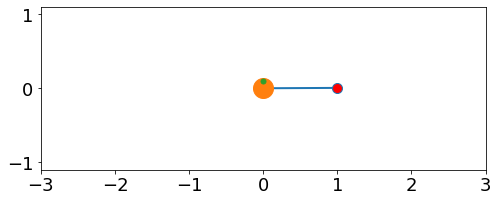

In [9]:

anim = animate_segway(result, ts, (x(t), theta(t)))
HTML(anim.to_jshtml())
        

# Adding control

In [10]:
# Storing the cumbersome partial derivative function in a lambdax2
ddx = lambda f,x:sp.diff(f,x)

# Defining variables to store rates of change
xd_val,  thetad_val  = x_d, theta_d
xdd_val, thetadd_val = DEexplicit

# Storing states and their change in variables
Xs  = [x(t),   x_d,      theta(t),   theta_d]
Xds = [xd_val, xdd_val, thetad_val, thetadd_val]

#  the stationary point Substitution. 
# We are linearising about the vertical, mass up position
subs_stationary = {
    theta(t)      : 0,
    ddt(theta(t)) : 0,
    ddt(x(t)) : 0
}

A_sp = sp.Matrix([ [  ddx(x_d,x  ).simplify().subs(subs_stationary) for x in Xs]  for x_d in Xds])
B_sp = sp.Matrix([ [  ddx(x_d,tau).simplify().subs(subs_stationary)]              for x_d in Xds])

### Using LQR to calculate the gain

In [17]:
# The Parameters for substitution to get numerical values
param_subs = {
    mw : param_vals["mw"],
    mb : param_vals["mb"],
    g  : param_vals["g"],
    l  : param_vals["l"],
    r  : param_vals["r"]
}

# Matrices with numerical values
A_np  = np.array(A_sp.subs(param_subs))
B_np  = np.array(B_sp.subs(param_subs))
Q     = np.eye(4)
R     = 0.001

# Modifying the coefficient so the horizontal position will be 
# minimally influenced by control. We want ot focus on controlling
# the velocity
# Q[0,0] = 0.000000001


# Use the LQR algorithm 
K_np  = np.array(ct_matlab.lqr(A_np, B_np, Q, R)[0])

### Simulating segway with control

In [20]:

# Simulation parameters
dt = 0.001
t0 = 0.0
tn = 10.0
ts = np.arange(t0, tn, dt)
t_step = [0.0, dt]

# Initial condition
x0  = np.array([1, 0, 0.1, 0])

# Set point
xsp = np.array([1, 0, 0, 0])

# Controller function
control_law = lambda x: -(K_np @(x-xsp))[0]

# Integrate
res_ctrl = odeint(
        get_Sewgway_Lagrangian, x0, ts, 
        args=(control_law, param_vals["mw"], param_vals["mb"], param_vals["l"], param_vals["r"], param_vals["g"])
)


<class 'matplotlib.lines.Line2D'>


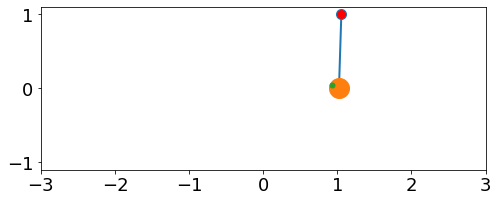

In [21]:
anim = animate_segway(res_ctrl, ts, (x(t), theta(t)))
HTML(anim.to_jshtml())       